In [178]:
#Libaries to Import
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

import matplotlib
import seaborn as sns


In [179]:
#Data 
df = pd.read_csv("data/ebit.csv", delimiter=";", decimal=",")
df.columns = ['year','ebit']
df.head(3)
df.describe()

,ebit
count,91.000000
mean,1032.912088
std,693.235645
min,-448.000000
25%,480.000000
50%,1005.000000
75%,1442.500000
max,2627.000000


In [180]:
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 2015-01
Time period end: 2022-07


In [181]:
df.columns

Index(['year', 'ebit'], dtype='object')

In [182]:
#Converting to datetime format:
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

In [183]:
#Setting index as the datetime column for easier manipulations: 
y = df.set_index('year')
y.index 

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
     

In [184]:
y.isnull().sum()

ebit    0
dtype: int64

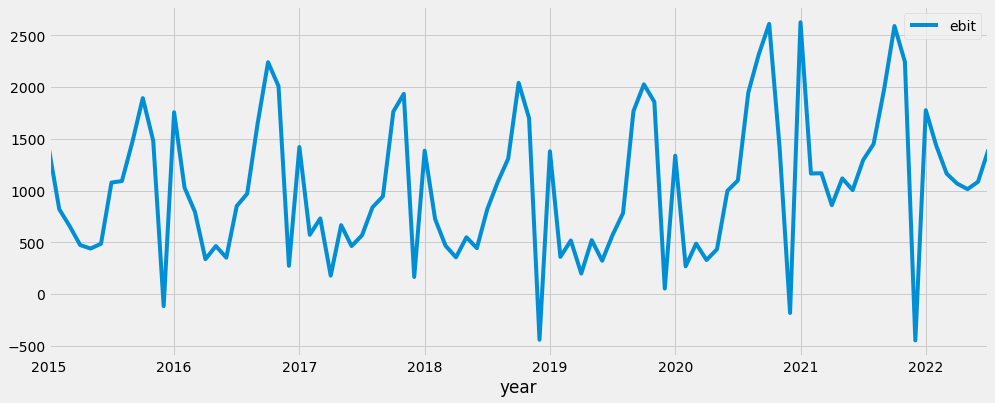

In [185]:
y.plot(figsize=(15, 6))
plt.show()

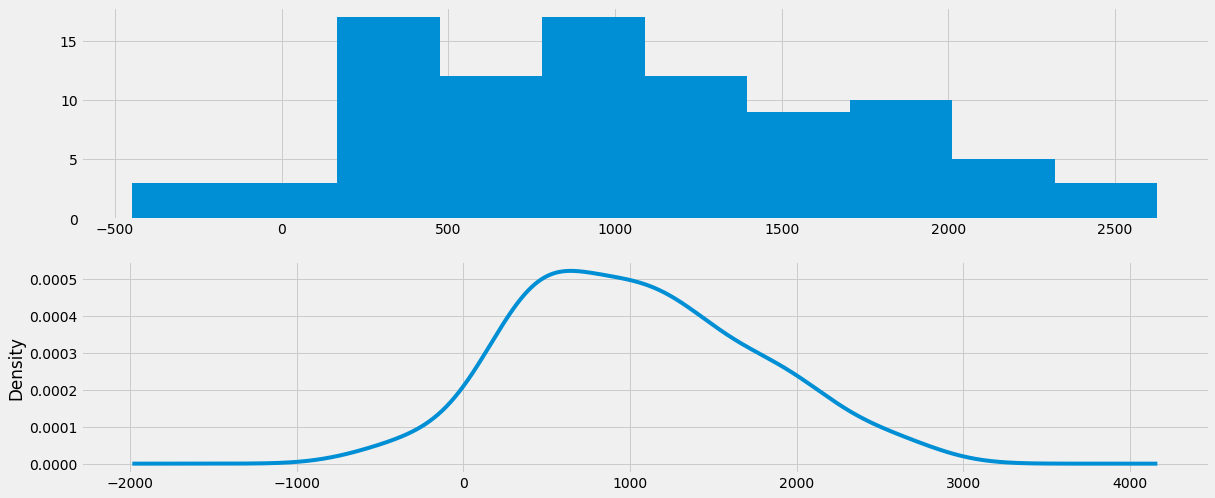

In [186]:
#Reviewing plots of the density of observations can provide further insight into the structure of the data: 
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.ebit.hist()
pyplot.subplot(212)
y.ebit.plot(kind='kde')
pyplot.show()

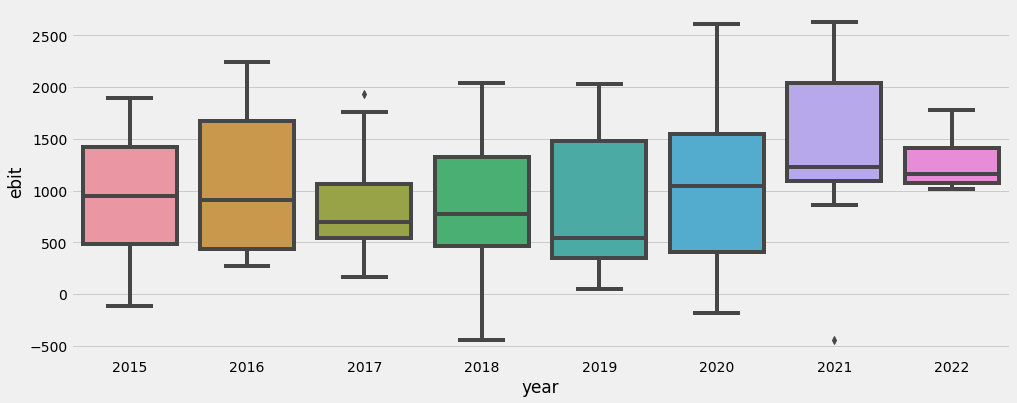

In [187]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.ebit.index.year, y.ebit, ax=ax)

In [188]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()


ValueError: Multiplicative seasonality is not appropriate for zero and negative values

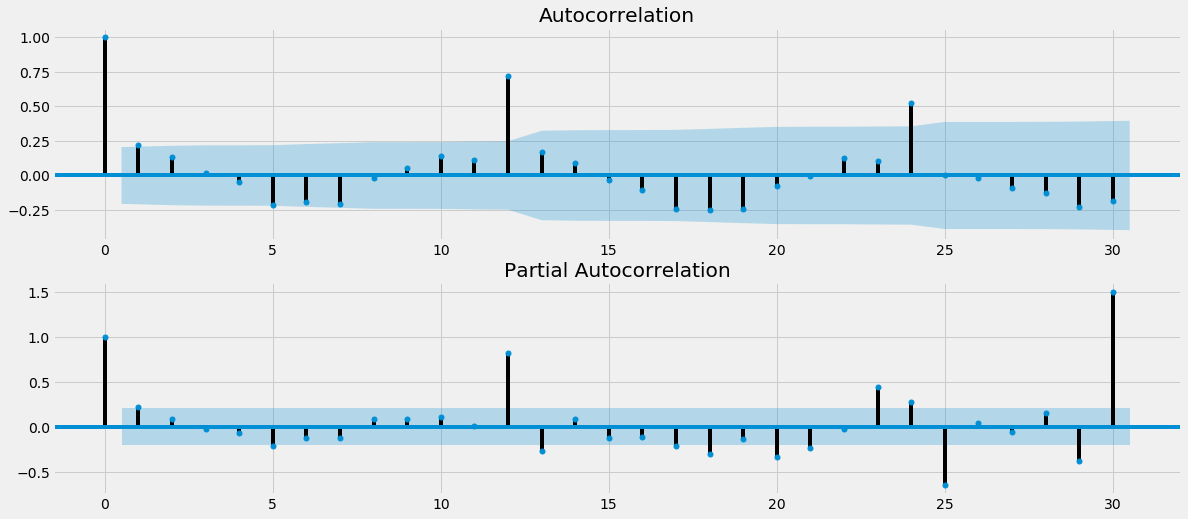

In [189]:
#Stationarity 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.ebit, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.ebit, ax=pyplot.gca(), lags = 30)
pyplot.show()

In [191]:
#Augmented Dickey-Fuller Test & Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.ebit, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                 -0.305640
p-value                         0.924702
#Lags Used                     12.000000
Number of Observations Used    78.000000
Critical Value (1%)            -3.517114
Critical Value (5%)            -2.899375
Critical Value (10%)           -2.586955
dtype: float64


In [192]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [193]:
#ARIMA 
ts = y.ebit - y.ebit.shift()
ts.dropna(inplace=True)

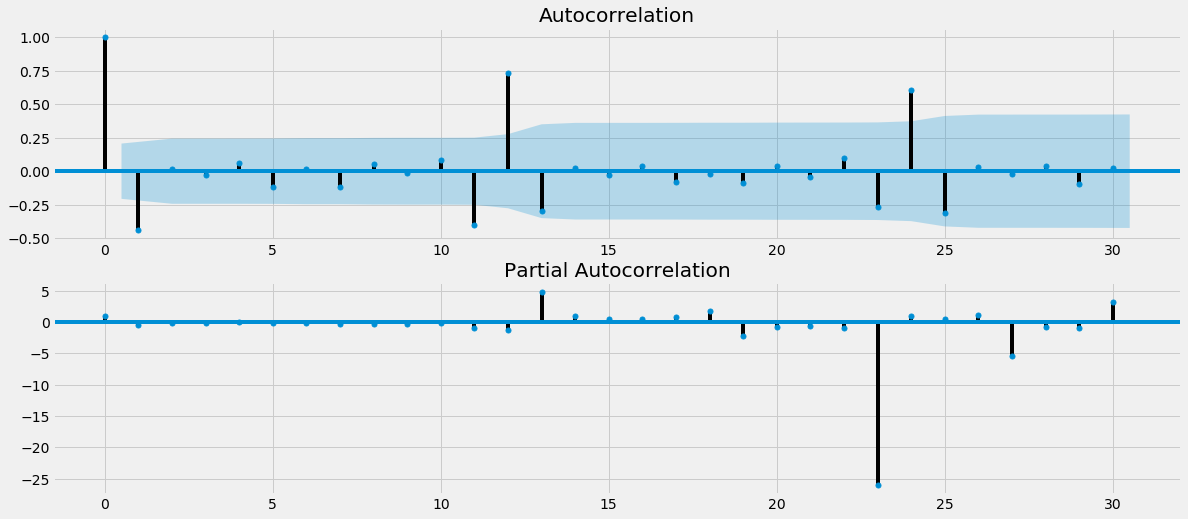

In [194]:
#ACF and PACF plots after differencing:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

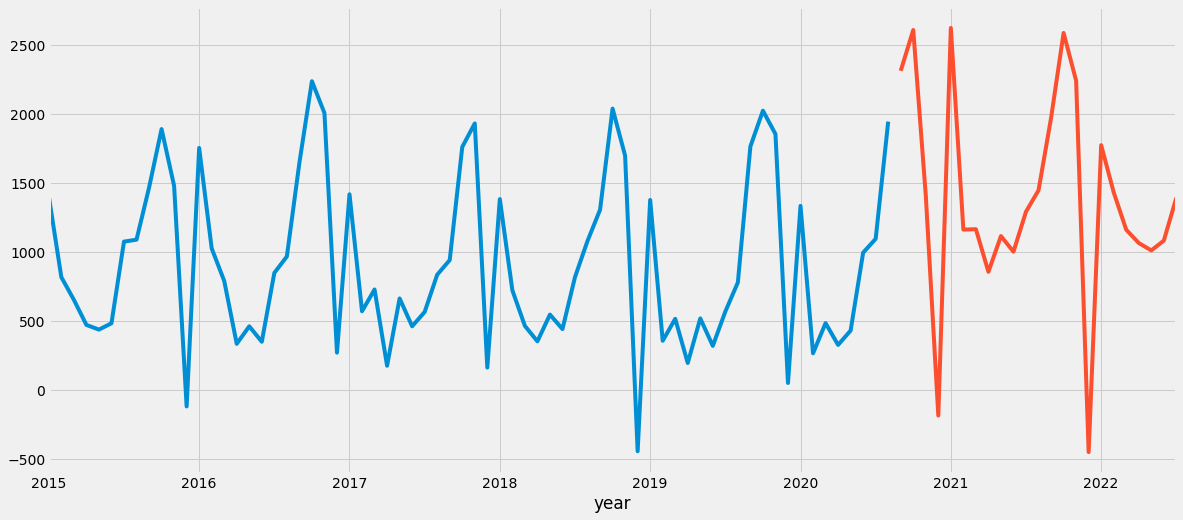

In [195]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['ebit'].plot()
valid['ebit'].plot()

In [196]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit(disp=1)

In [197]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.ebit   No. Observations:                   67
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -526.142
Method:                       css-mle   S.D. of innovations            605.432
Date:                Thu, 13 Oct 2022   AIC                           1060.284
Time:                        19:46:12   BIC                           1069.103
Sample:                    02-01-2015   HQIC                          1063.774
                         - 08-01-2020                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.8735      4.825     -0.181      0.856     -10.331       8.584
ar.L1.D.ebit     0.2347      0.123      1.904      0.057      -0.007       0.476
ma.L1.D.ebit    -1.0000      0.039    -25.577      0.000      -1.077      -0.923
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.2607           +0.0000j            4.2607            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [198]:
#SARIMA Modeling
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [199]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1129.6840027363287
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1026.5297155765093
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1022.1894655697712
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:866.8826452251641
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1026.2370903564117
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:968.7571217838783
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:811.0685034555618
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:795.1943856584587
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1089.7829416256427
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:992.398805070104
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:998.9158457924564
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:846.8444099637888
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1014.6656954623811
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:947.7278992080694
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:805.6282517334257
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:774.1367314279686
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:1066.528649481105
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:976.8117735369481
ARIMA(0, 1, 0)x(0, 1, 0

In [200]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              ebit   No. Observations:                   68
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -381.387
Date:                           Thu, 13 Oct 2022   AIC                            770.774
Time:                                   19:46:28   BIC                            778.655
Sample:                               01-01-2015   HQIC                           773.804
                                    - 08-01-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9641      0.660     -2.977      0.003      -3.257      -0.671
ar.S.L6       -1.0115      0.054    -18.804      0.000      -1.117      -0.906
ma.S.L6       -8.5092     14.845     -0.573      0.567     -37.605      20.587
sigma2       345.2353   1393.308      0.248      0.804   -2385.599    3076.070
===================================================================================
Ljung-Box (Q):                       89.35   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.00   Prob(JB):                         0.98
Heteroskedasticity (H):               1.11   Skew:                            -0.06
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [201]:
#Period for forecast
start_analysis = "2015-01"
end_analysis = "2023-12"

#Predictions
pred = min_aic_model.get_prediction(start=start_analysis,end=end_analysis, dynamic=False)

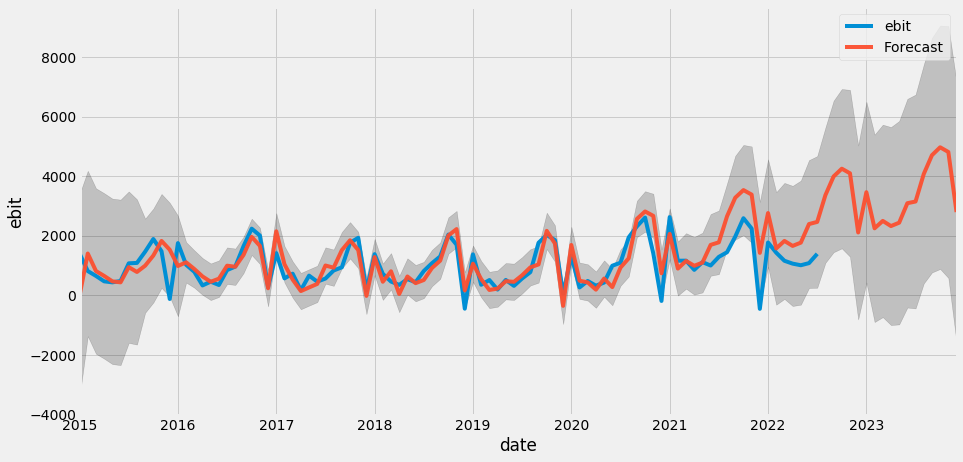

2015-01-01       0.000000
2015-02-01    1407.000000
2015-03-01     820.198985
2015-04-01     656.055624
2015-05-01     474.061673
                 ...     
2023-08-01    4071.643799
2023-09-01    4702.857155
2023-10-01    4968.516917
2023-11-01    4811.169740
2023-12-01    2797.459689
Freq: MS, Length: 108, dtype: float64
             lower ebit   upper ebit
2015-01-01 -3394.757202  3394.757202
2015-02-01 -1365.046870  4179.046870
2015-03-01 -1952.770410  3593.168380
2015-04-01 -2116.913771  3429.025019
2015-05-01 -2298.907721  3247.031068
...                 ...          ...
2023-08-01   404.118151  7739.169447
2023-09-01   772.381965  8633.332346
2023-10-01   889.377643  9047.656192
2023-11-01   588.597157  9033.742323
2023-12-01 -1563.831544  7158.750922

[108 rows x 2 columns]


In [202]:
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.95, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('date')
ax.set_ylabel('ebit')
plt.legend()
plt.show()

print(pred.predicted_mean)
print(pred_ci)

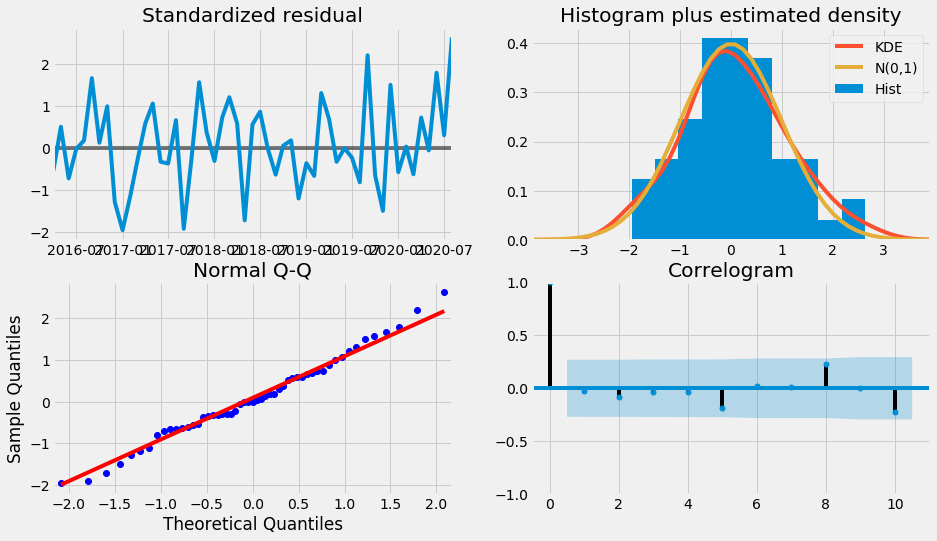

In [175]:
results.plot_diagnostics(figsize=(14, 8))
plt.show()

In [176]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [177]:
#Evaluate Forecast
y_forecasted = pred.predicted_mean.values
y_truth = y[start_analysis:end_analysis].revenue.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

ValueError: operands could not be broadcast together with shapes (108,) (91,) 

In [162]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 342.97


In [163]:
evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,rmse
0,0.90994,281.10945,295.144975,117629.532157,342.97162
